# Bayesian Regression

In [1]:
using Gen
using PyPlot

┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


## Define the model

A simple least-squares regressor:

$$ x_1, \ldots, x_n \ \text{given}$$

$$ A \sim \text{Gamma}(2,1)$$

$$ \omega \sim \text{Exponential}(1/2) $$

$$ \phi \sim \text{Uniform}(0, 2\pi)$$

$$ \sigma \sim \text{Exponential}(2)$$

$$ y_i \sim N( A \sin(\omega x_i + \phi), \sigma) \ \ \forall i \in [n]$$

In [2]:
@gen function sinusoid_regressor(xs)

    # Prior distributions for the model parameters
    amplitude = @trace(Gen.gamma(2.0, 1.0), :amplitude)
    phi = @trace(Gen.uniform_continuous(0.0, pi), :phi)
    omega = @trace(Gen.exponential(0.5), :omega)

    ys = zeros(length(xs))
    for i=1:length(xs)
        ys[i] = @trace(Gen.normal( amplitude*sin(omega*xs[i] + phi), 1), :y => i)
    end
    
    return ys
    
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##sinusoid_regressor#371, Bool[0], false)

## Simulate some data

In [3]:
xs = collect(0:0.1:10)
sim_tr = Gen.simulate(sinusoid_regressor, (xs,))
choices = get_choices(sim_tr)
ys = get_retval(sim_tr);

In [4]:
println(choices)

│
├── :amplitude : 1.0525389882049956
│
├── :omega : 0.5919257632508469
│
├── :phi : 1.8110173914290357
│
└── :y
    │
    ├── 68 : -0.736961207070189
    │
    ├── 2 : 1.7464051957818434
    │
    ├── 89 : -0.3291604637770972
    │
    ├── 11 : 2.4709814447744245
    │
    ├── 39 : -0.3858973128395773
    │
    ├── 46 : -1.28531376475343
    │
    ├── 85 : 1.1112279146142416
    │
    ├── 25 : -0.07279087757738276
    │
    ├── 55 : -0.6212678927282335
    │
    ├── 42 : -0.8383667541036062
    │
    ├── 29 : 1.090896041894961
    │
    ├── 58 : -2.205018043871691
    │
    ├── 66 : 0.08566379281683356
    │
    ├── 59 : 0.2867987569576539
    │
    ├── 8 : 1.4024708717218592
    │
    ├── 74 : -0.7808977848205305
    │
    ├── 95 : 0.9876811173555137
    │
    ├── 57 : -2.073266764034753
    │
    ├── 20 : -1.3069465060447152
    │
    ├── 90 : 0.818631981349755
    │
    ├── 14 : 0.751463428385629
    │
    ├── 31 : 0.9547942164725839
    │
    ├── 78 : 0.11081758406636015
    │
   

In [5]:
function visualize_trace(trace, color, linewidth)
    xs = get_args(trace)[1]
    choices = get_choices(trace)
    true_ys = choices[:amplitude].*sin.(choices[:omega].*xs .+ choices[:phi])
    plot(xs, true_ys, color=color, linewidth=linewidth)
end;

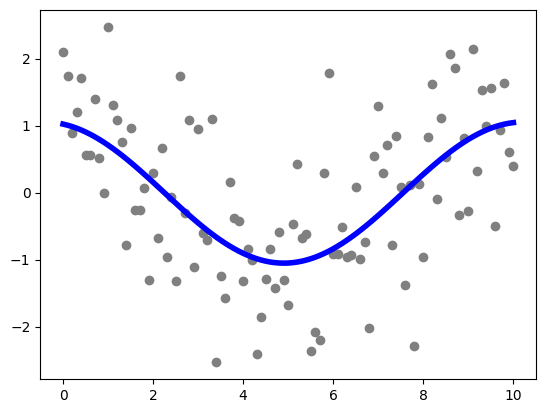

In [6]:
scatter(xs, ys, color="gray")
visualize_trace(sim_tr, "blue", 4.0)
show()

## Condition the model on observations

In [7]:
observations = Gen.choicemap()

for i=1:length(ys)
    observations[:y => i] = ys[i]
end


## Perform inference: importance resampling

In [8]:
function ir_inference_program(xs, observations, n_samples, thinning)
    
    traces = []
    
    for i=1:n_samples
        tr, _ = Gen.importance_resampling(sinusoid_regressor, (xs,), 
                                          observations, thinning)
        push!(traces, tr)
    end
    
    return traces
end

ir_inference_program (generic function with 1 method)

In [9]:
traces = ir_inference_program(xs, observations, 500, 200);

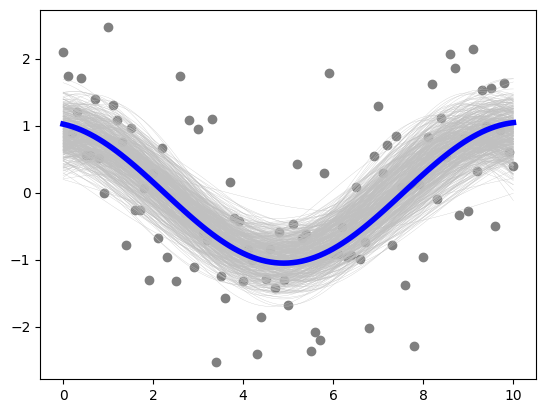

In [10]:
scatter(xs, ys, color="gray")
for tr in traces
    visualize_trace(tr, "silver", 0.2)
end
visualize_trace(sim_tr, "blue", 4.0)
show()

In [11]:
amps = [tr[:amplitude] for tr in traces]
omegas = [tr[:omega] for tr in traces]
phis = [tr[:phi] for tr in traces];

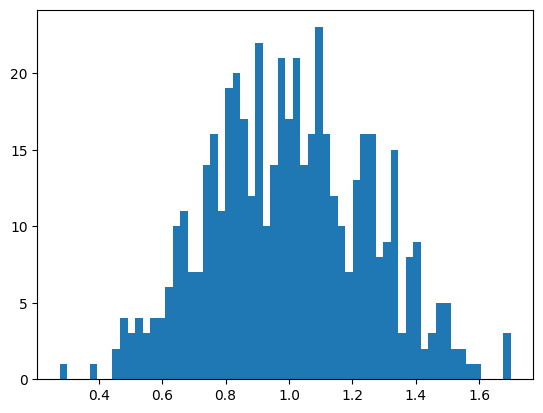

In [12]:
hist(amps, bins=60)
show()

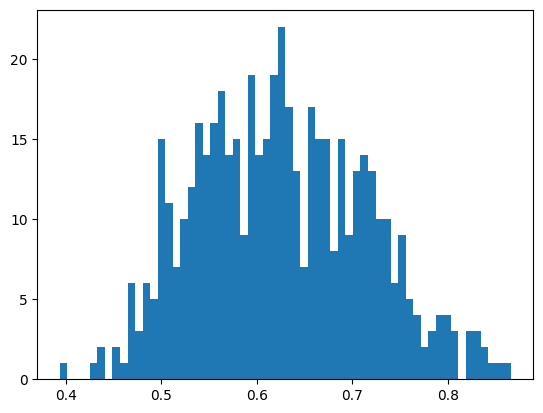

In [13]:
hist(omegas, bins=60)
show()

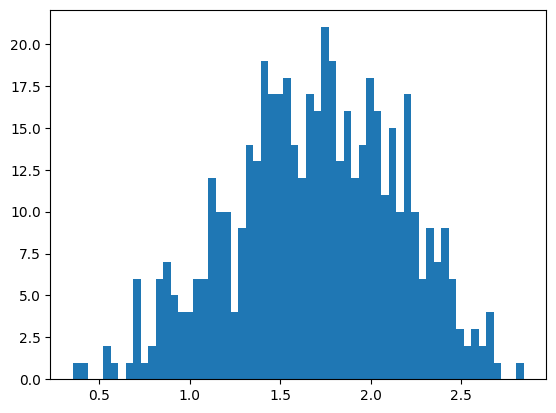

In [14]:
hist(phis, bins=60)
show()